# Skin Cancer Detection models 🩺 | CNN, NN and Logistic Regression

#### Prologue
This notebook explores melanoma classification using machine learning.
The objective is **construct** and **analyze** three models: a neural network, logistic regression, and a CNN.

#### Dataset Overview
Comprising 13,900 uniformly-sized images at 224 x 224 pixels, which provides a comprehensive portrayal of diverse manifestations of melanoma. Each image is meticulously labeled as either `benign` or `malignant`.

In [1]:
import asyncio
asyncio.set_event_loop_policy(asyncio.WindowsSelectorEventLoopPolicy())
#----------
import os
import random
#----------
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
#----------
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, mean_squared_error, accuracy_score, precision_score, recall_score
#----------
import pandas as pd
#----------
import matplotlib.pyplot as plt
#----------
import numpy as np
#----------
from PIL import Image
#----------
import warnings
warnings.filterwarnings('ignore')

## Load and preprocess the dataset

In [2]:
# Path to the dataset archive
archive_path = r'C:\Users\yair8\Skin-Cancer-Detection-Project\dataSet'

In [3]:
# Define the main folder path after extraction
main_folder_path = os.path.splitext(archive_path)[0]  # Remove the extension

The main folder contains 2 folders - train and test - and each of them conatins 2 folder - Benign and Malignant

In [4]:
# Define subfolders
data_folders = ["train", "test"]
class_folders = ["Benign", "Malignant"]

In [5]:
# Paths for train and test data
train_data_path = os.path.join(main_folder_path, data_folders[0])
test_data_path = os.path.join(main_folder_path, data_folders[1])

Set those hyperparamaters as you wish

In [6]:
img_width, img_height = 112, 112 
batch_size = 128
epochs = 15

In [7]:
# Data generators
train_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_data_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 11879 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


### Samples Examples

In [8]:
# Get the first batch from the training generator
x_batch, y_batch = next(train_generator)

# Extract features and label from the first element in the batch
first_features = x_batch[0]
first_label = y_batch[0]

# Get the mapping of class indices to class names
class_indices = train_generator.class_indices

# Reverse the mapping to get class names to class indices
class_names = {v: k for k, v in class_indices.items()}

# Extract the numerical label of the first element in the batch
numerical_label = int(first_label)

# Get the corresponding class name
label_name = class_names[numerical_label]
print(int(first_label), "stands for", label_name)

1 stands for Malignant


In [9]:
# Display information about the dataset
shapes = np.shape(train_generator[0][0])
print("A batch contains", shapes[0], "samples of", shapes[1], "x", shapes[2], "x", shapes[3])

A batch contains 128 samples of 112 x 112 x 3


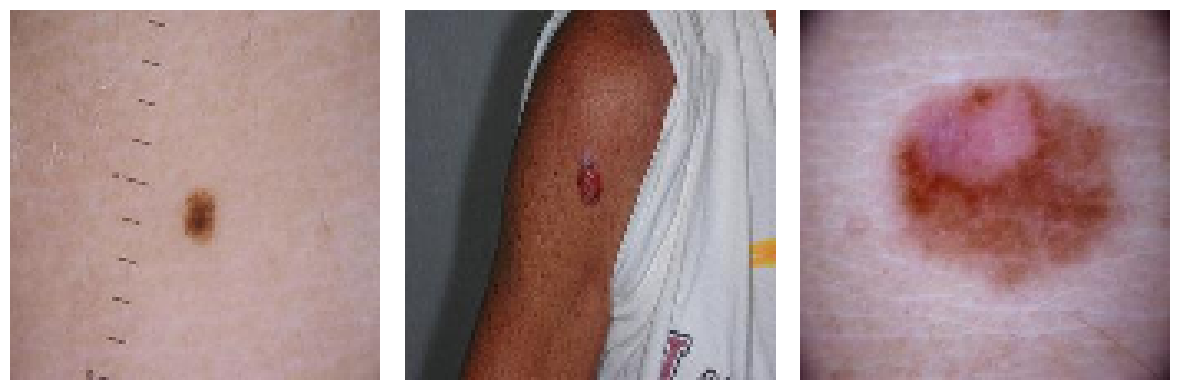

In [10]:
# Select 3 random indices from the list
random_indices = random.sample(range(len(train_generator)), 3)

# Display the selected images in a 3x1 grid
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for i, index in enumerate(random_indices):
    # Show each image
    image = train_generator[index][0][0]
    axes[i].imshow(image)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# Models

This section involves constructing three models: a Neural Network (NN), Logistic Regression, and Convolutional Neural Network (CNN). Each model is analyzed individually, followed by a comparative evaluation to discern their respective performance characteristics.

## BaseLine Model

### Creation

In [11]:
def create_baseline_model(train_generator):
    """
    Create a baseline model that predicts the majority class.

    Parameters:
    - train_generator: The training data generator.

    Returns:
    - majority_class_index: The index of the most frequent class in the training data.
    """
    # Extract labels from the training generator
    labels = train_generator.classes
    
    # Find the most frequent class (numeric index)
    majority_class_index = np.argmax(np.bincount(labels))
    
    # Print information about the majority class
    for class_name, index in train_generator.class_indices.items():
        if index == majority_class_index:
            print(f"The majority class is: {class_name} (Index: {majority_class_index})")
            break
    
    return majority_class_index

### Training and Evaluating

In [12]:
def evaluate_baseline_model(majority_class_index, test_generator):
    """
    Evaluate the baseline model.

    Parameters:
    - majority_class_index: The index of the most frequent class.
    - test_generator: The test data generator.

    Returns:
    - predicted_labels: Predicted labels (all as the majority class).
    - true_labels: True labels from the test data.
    """
    # Extract true labels from the test generator
    true_labels = test_generator.classes
    
    # Generate predictions (all as the majority class index)
    predicted_labels = np.full_like(true_labels, fill_value=majority_class_index)
    
    return predicted_labels, true_labels

### Training Results

In [13]:
model_type = 'baseLine'
# Create the baseline model
baseline_majority_class = create_baseline_model(train_generator)

# Evaluate the baseline model
baseline_predictions, baseline_true_labels = evaluate_baseline_model(baseline_majority_class, test_generator)

# Display results
print(f"Baseline Predictions (first 10): {baseline_predictions[:10]}")
print(f"True Labels (first 10): {baseline_true_labels[:10]}")

The majority class is: Benign (Index: 0)
Baseline Predictions (first 10): [0 0 0 0 0 0 0 0 0 0]
True Labels (first 10): [0 0 0 0 0 0 0 0 0 0]


### Model Evaluation Metrics

In [14]:
# Calculate accuracy
baseline_accuracy = accuracy_score(baseline_true_labels, baseline_predictions)

# Calculate precision
baseline_precision = precision_score(baseline_true_labels, baseline_predictions, pos_label=1)

# Calculate recall
baseline_recall = recall_score(baseline_true_labels, baseline_predictions, pos_label=1)

# Display metrics
print("Baseline Model Metrics:")
print(f"- Accuracy:  {baseline_accuracy:.4f}")
print(f"- Precision: {baseline_precision:.4f}")
print(f"- Recall:    {baseline_recall:.4f}")


Baseline Model Metrics:
- Accuracy:  0.5000
- Precision: 0.0000
- Recall:    0.0000


### Classification Report

In [15]:
# Generate classification report
baseline_report = classification_report(
    baseline_true_labels,
    baseline_predictions,
    target_names=list(test_generator.class_indices.keys())
)

# Display the classification report
print("\nClassification Report:\n")
print(baseline_report)


Classification Report:

              precision    recall  f1-score   support

      Benign       0.50      1.00      0.67      1000
   Malignant       0.00      0.00      0.00      1000

    accuracy                           0.50      2000
   macro avg       0.25      0.50      0.33      2000
weighted avg       0.25      0.50      0.33      2000



### Confusion Matrix

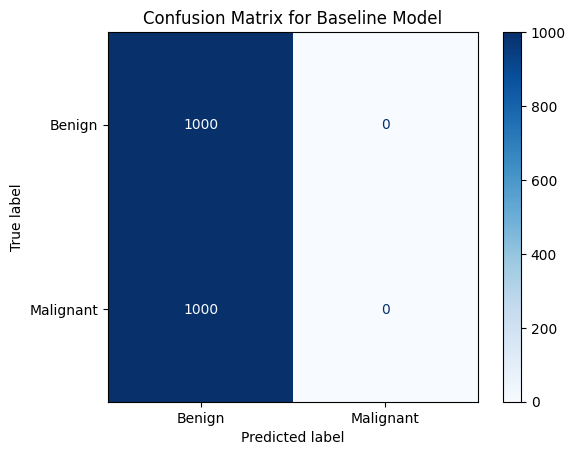

In [16]:
# Generate confusion matrix
baseline_cm = confusion_matrix(baseline_true_labels, baseline_predictions)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=baseline_cm, display_labels=list(test_generator.class_indices.keys()))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix for Baseline Model")
plt.show()

## Neural Network 

### Creation

In [17]:
def create_nn(num_hidden_layers, hidden_layer_sizes, learning_rate=0.0001):
    """
    Create a neural network with dynamic hidden layers and a specified learning rate.

    Parameters:
    - num_hidden_layers: Integer specifying the number of hidden layers for each set of sizes.
    - hidden_layer_size: List of integers specifying the size of each hidden layer.
    - learning_rate: Float specifying the learning rate.
    """
    model = Sequential()
    
    # Flatten the input data
    model.add(Flatten(input_shape=(img_width, img_height, 3)))

    # Add hidden layers with dropout
    for i in range(num_hidden_layers):
        model.add(tf.keras.layers.Dense(hidden_layer_sizes[i], activation='relu'))
            
    # Output layer with binary classification
    model.add(Dense(1, activation='sigmoid')) 

    # Compile the model with specified learning rate
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy'])

    return model

In [18]:
# Define NN sizes
hidden_layer_sizes = [128, 64, 64]
num_hidden_layers = len(hidden_layer_sizes)

# Get the NN model
nn_model = create_nn(num_hidden_layers, hidden_layer_sizes)

# Display the model architecture
nn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 37632)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,817,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,829,505 (18.42 MB)

 Trainable params: 4,829,505 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

### Training and evaluating

In [19]:
model_type = 'NN'
history = nn_model.fit(train_generator, epochs=epochs, validation_data=test_generator)

# Evaluate the model
test_loss, test_acc = nn_model.evaluate(test_generator)
print(f'Test Accuracy: {test_acc}')

Epoch 1/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - accuracy: 0.6533 - loss: 0.6380 - val_accuracy: 0.7335 - val_loss: 0.4867
Epoch 2/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 125ms/step - accuracy: 0.7882 - loss: 0.4435 - val_accuracy: 0.7865 - val_loss: 0.4552
Epoch 3/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 122ms/step - accuracy: 0.8039 - loss: 0.4213 - val_accuracy: 0.7795 - val_loss: 0.4445
Epoch 4/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 120ms/step - accuracy: 0.8058 - loss: 0.4205 - val_accuracy: 0.6860 - val_loss: 0.5390
Epoch 5/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 119ms/step - accuracy: 0.8106 - loss: 0.4069 - val_accuracy: 0.8040 - val_loss: 0.4301
Epoch 6/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 120ms/step - accuracy: 0.8138 - loss: 0.3944 - val_accuracy: 0.7285 - val_loss: 0.4906
Epoch 7/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - accuracy: 0.8303 - loss: 0.3714 - val_accuracy: 0.7465 - val_loss: 0.4596
Epoch 8/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 123ms/step - accuracy: 0.8287 - loss: 0.3687 - val_accu

### Training Results

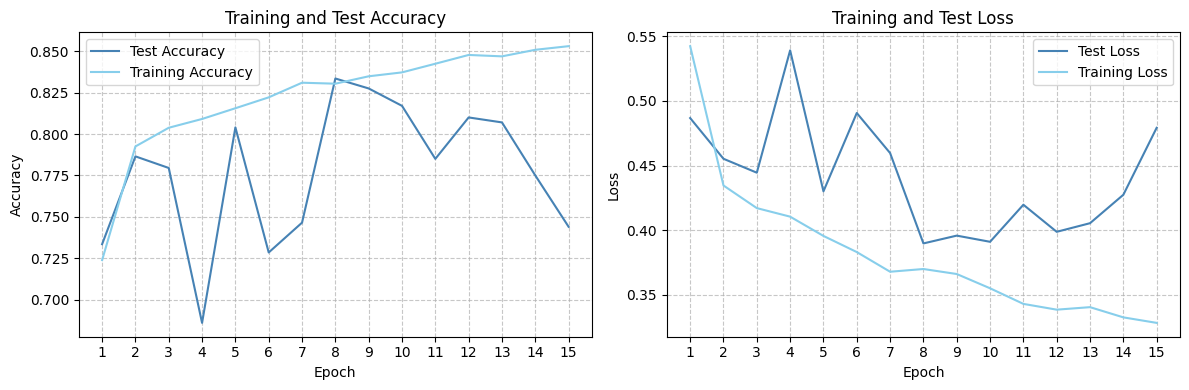

In [20]:
# Plot training and test accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(np.arange(1, len(history.history['val_accuracy']) + 1), history.history['val_accuracy'], label='Test Accuracy', color="steelblue")
plt.plot(np.arange(1, len(history.history['accuracy']) + 1), history.history['accuracy'], label='Training Accuracy', color="skyblue")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(range(1, len(history.history['accuracy']) + 1))
plt.legend()

# Plot training and test loss values
plt.subplot(1, 2, 2)
plt.plot(np.arange(1, len(history.history['val_loss']) + 1), history.history['val_loss'], label='Test Loss', color="steelblue")
plt.plot(np.arange(1, len(history.history['loss']) + 1), history.history['loss'], label='Training Loss', color="skyblue")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(range(1, len(history.history['loss']) + 1))
plt.legend()

plt.tight_layout()
plt.show()

### Model Evaluation Metrics

In [21]:
# Evaluate the model on the test data and get predictions
predicted_probabilities = nn_model.predict(test_generator)

# Convert probabilities to binary predictions (0 or 1)
predicted_labels = np.round(predicted_probabilities).astype(np.int32)

# Get true labels
true_labels = test_generator.classes

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(true_labels, predicted_labels)

# Calculate Accuracy
accuracy = accuracy_score(true_labels, predicted_labels)

# Calculate Precision
precision = precision_score(true_labels, predicted_labels)

# Calculate Recall
recall = recall_score(true_labels, predicted_labels)

print(f'MSE:       {mse:.5f}')
print(f'Accuracy:  {accuracy:.5f}')
print(f'Precision: {precision:.5f}')
print(f'Recall:    {recall:.5f}')

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step
MSE:       0.25600
Accuracy:  0.74400
Precision: 0.94364
Recall:    0.51900


### Classification Report

In [22]:
# Generate classification report
report = classification_report(true_labels, predicted_labels, target_names=["Benign", "Malignant"])
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

      Benign       0.67      0.97      0.79      1000
   Malignant       0.94      0.52      0.67      1000

    accuracy                           0.74      2000
   macro avg       0.81      0.74      0.73      2000
weighted avg       0.81      0.74      0.73      2000



### Confution Matrix

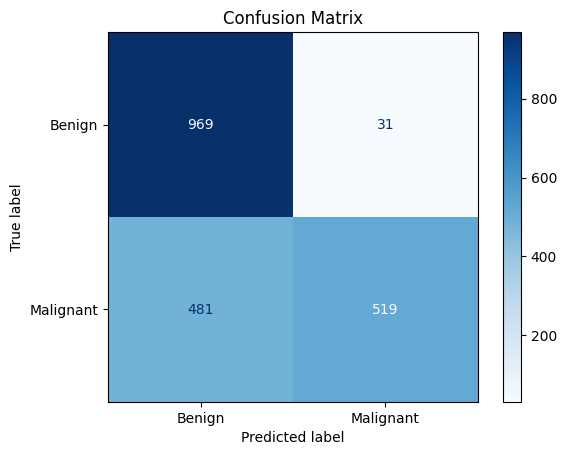

In [23]:
# Generate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benign", "Malignant"])
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()

## Logistic Regression

### Creation

In [24]:
def create_logistic_regression_model(input_shape, num_classes):
    """
    Create a logistic regression model.

    Parameters:
    - input_shape: Tuple, shape of the input data (e.g., (height, width, channels)).
    - num_classes: Integer, number of classes for classification.

    Returns:
    - lr_model: Compiled logistic regression model.
    """
    lr_model = Sequential()
  
    # Add an input layer with the specified input shape
    lr_model.add(tf.keras.Input(shape=input_shape))

    # Flatten the input
    lr_model.add(tf.keras.layers.Flatten())

    # Add a dense layer with the number of classes
    lr_model.add(tf.keras.layers.Dense(num_classes))
        
    # Apply softmax activation to the output layer
    lr_model.add(tf.keras.layers.Softmax())
    
    # Compile the model with Adam optimizer, sparse categorical crossentropy loss, and accuracy metric
    lr_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
    )

    return lr_model

In [25]:
# Model parameters
input_shape = (img_width, img_height, 3)
num_classes = 2

In [26]:
# Get model
lr_model = create_logistic_regression_model(input_shape, num_classes)

# Display the model architecture
lr_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 37632)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 2)              │        75,266 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax (Softmax)               │ (None, 2)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,266 (294.01 KB)

 Trainable params: 75,266 (294.01 KB)

 Non-trainable params: 0 (0.00 B)

### Training and evaluating

In [27]:
model_type = 'Logistic Regression'
# Train
lr_history = lr_model.fit(
  train_generator,
  epochs=epochs,
  validation_data=test_generator  
)

# Evaluate
test_loss, test_acc = lr_model.evaluate(test_generator)
print('Test accuracy:', test_acc)

Epoch 1/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 90ms/step - accuracy: 0.5657 - loss: 3.9382 - val_accuracy: 0.5960 - val_loss: 0.7733
Epoch 2/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 88ms/step - accuracy: 0.7012 - loss: 0.6072 - val_accuracy: 0.5735 - val_loss: 0.9664
Epoch 3/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 88ms/step - accuracy: 0.7110 - loss: 0.6424 - val_accuracy: 0.5900 - val_loss: 0.9042
Epoch 4/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step - accuracy: 0.6889 - loss: 0.7163 - val_accuracy: 0.7520 - val_loss: 0.5202
Epoch 5/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 88ms/step - accuracy: 0.7804 - loss: 0.5105 - val_accuracy: 0.5995 - val_loss: 0.9830
Epoch 6/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 88ms/step - accuracy: 0.7747 - loss: 0.5097 - val_accuracy: 0.6850 - val_loss: 0.6058
Epoch 7/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - accuracy: 0.6816 - loss: 0.8760 - val_accuracy: 0.5865 - val_loss: 1.1443
Epoch 8/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 97ms/step - accuracy: 0.7445 - loss: 0.6064 - val_accuracy: 0.6520 - v

### Training Results

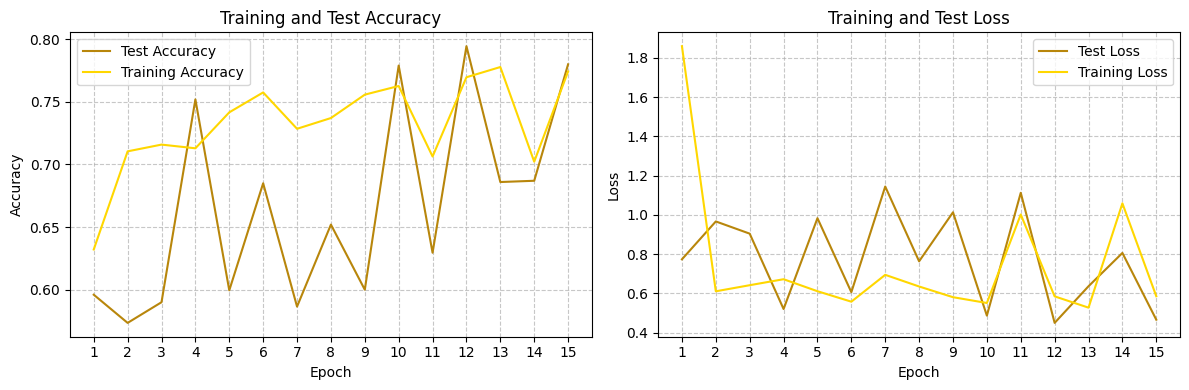

In [28]:
# Plot training and test accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(np.arange(1, len(lr_history.history['val_accuracy']) + 1), lr_history.history['val_accuracy'], label='Test Accuracy', color='darkgoldenrod')
plt.plot(np.arange(1, len(lr_history.history['accuracy']) + 1), lr_history.history['accuracy'], label='Training Accuracy', color='gold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(range(1, len(lr_history.history['val_accuracy']) + 1))
plt.legend()

# Plot training and test loss values
plt.subplot(1, 2, 2)
plt.plot(np.arange(1, len(lr_history.history['val_loss']) + 1), lr_history.history['val_loss'], label='Test Loss', color='darkgoldenrod')
plt.plot(np.arange(1, len(lr_history.history['loss']) + 1), lr_history.history['loss'], label='Training Loss', color='gold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(range(1, len(lr_history.history['val_loss']) + 1))
plt.legend()

plt.tight_layout()
plt.show()

### Model Evaluation Metrics

In [29]:
# Evaluate the model on the test data and get predictions
predicted_probabilities = lr_model.predict(test_generator)

# Convert probabilities to binary predictions (0 or 1)
predicted_labels = np.round(predicted_probabilities).astype(np.int32)[:, 1]  # [:, 0] is the probabily to mistake.

# Get true labels
true_labels = test_generator.classes

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(true_labels, predicted_labels)

# Calculate Accuracy
accuracy = accuracy_score(true_labels, predicted_labels)

# Calculate Precision
precision = precision_score(true_labels, predicted_labels)

# Calculate Recall
recall = recall_score(true_labels, predicted_labels)

print(f'MSE:       {mse:.5f}')
print(f'Accuracy:  {accuracy:.5f}')
print(f'Precision: {precision:.5f}')
print(f'Recall:    {recall:.5f}')

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step
MSE:       0.22000
Accuracy:  0.78000
Precision: 0.85714
Recall:    0.67200


### Classification Report

In [30]:
# Generate classification report
report = classification_report(true_labels, predicted_labels, target_names=["Benign", "Malignant"])
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

      Benign       0.73      0.89      0.80      1000
   Malignant       0.86      0.67      0.75      1000

    accuracy                           0.78      2000
   macro avg       0.79      0.78      0.78      2000
weighted avg       0.79      0.78      0.78      2000



### Confusion Matrix

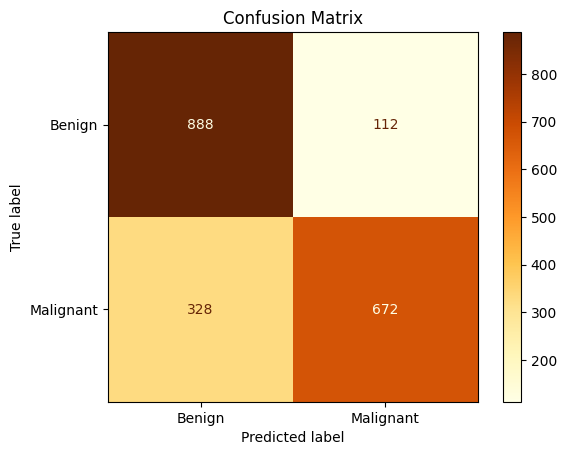

In [31]:
# Generate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benign", "Malignant"])
disp.plot(cmap='YlOrBr', values_format='d')
plt.title("Confusion Matrix")
plt.show()

## Convolutional Neural Network

### Creation

In [32]:
def create_cnn_model(input_shape, num_classes, 
                    conv_layers=2, 
                    conv_filters=32,
                    conv_kernel_size=(3,3),
                    conv_activation='relu',
                    pool_size=(2,2),
                    learning_rate=0.0001):

    # Create sequential model
    cnn_model = Sequential()
    
    # Add input layer
    cnn_model.add(Conv2D(conv_filters, kernel_size=conv_kernel_size, activation=conv_activation, input_shape=input_shape))
    cnn_model.add(BatchNormalization())
    cnn_model.add(MaxPooling2D(pool_size=pool_size))

    # Add convolutional layers
    for i in range(conv_layers):
        cnn_model.add(Conv2D(conv_filters, 
                             kernel_size=conv_kernel_size, 
                             activation=conv_activation))
        cnn_model.add(BatchNormalization())
        cnn_model.add(MaxPooling2D(pool_size=pool_size))

    # Fully connected layer with dropout
    cnn_model.add(Flatten())
    cnn_model.add(BatchNormalization())
    cnn_model.add(Dense(num_classes, activation='sigmoid'))

    # Compile the model with specified learning rate
    optimizer = Adam(learning_rate=learning_rate)
    cnn_model.compile(
                    optimizer=optimizer,
                    loss='binary_crossentropy',
                    metrics=['accuracy'])
  
    return cnn_model

In [33]:
# Model parameters
input_shape = (img_height, img_width, 3)
num_classes = 1

In [34]:
# Get model
cnn_model = create_cnn_model(input_shape, num_classes)

# Display the model architecture
cnn_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 110, 110, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 110, 110, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 55, 55, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 53, 53, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 53, 53, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 26, 26, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 4608)           │        18,432 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │         4,609 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,817 (167.25 KB)

 Trainable params: 33,409 (130.50 KB)

 Non-trainable params: 9,408 (36.75 KB)

### Training and evaluating

In [35]:
model_type = 'CNN'
# Train
cnn_history = cnn_model.fit(
  train_generator,
  epochs=epochs,
  validation_data=test_generator  
)

# Evaluate
test_loss, test_acc = cnn_model.evaluate(test_generator)
print('Test accuracy:', test_acc)

Epoch 1/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 69s 723ms/step - accuracy: 0.7896 - loss: 0.4637 - val_accuracy: 0.5000 - val_loss: 0.7944
Epoch 2/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 67s 720ms/step - accuracy: 0.8523 - loss: 0.3408 - val_accuracy: 0.5000 - val_loss: 0.9159
Epoch 3/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 68s 726ms/step - accuracy: 0.8665 - loss: 0.3179 - val_accuracy: 0.5000 - val_loss: 0.9461
Epoch 4/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 67s 722ms/step - accuracy: 0.8752 - loss: 0.2990 - val_accuracy: 0.5215 - val_loss: 0.7451
Epoch 5/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 68s 725ms/step - accuracy: 0.8770 - loss: 0.2850 - val_accuracy: 0.6470 - val_loss: 0.5691
Epoch 6/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 71s 760ms/step - accuracy: 0.8781 - loss: 0.2816 - val_accuracy: 0.7785 - val_loss: 0.4509
Epoch 7/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 68s 730ms/step - accuracy: 0.8880 - loss: 0.2668 - val_accuracy: 0.8315 - val_loss: 0.3599
Epoch 8/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 67s 721ms/step - accuracy: 0.8927 - loss: 0.2575 - val_accu

### Training Results

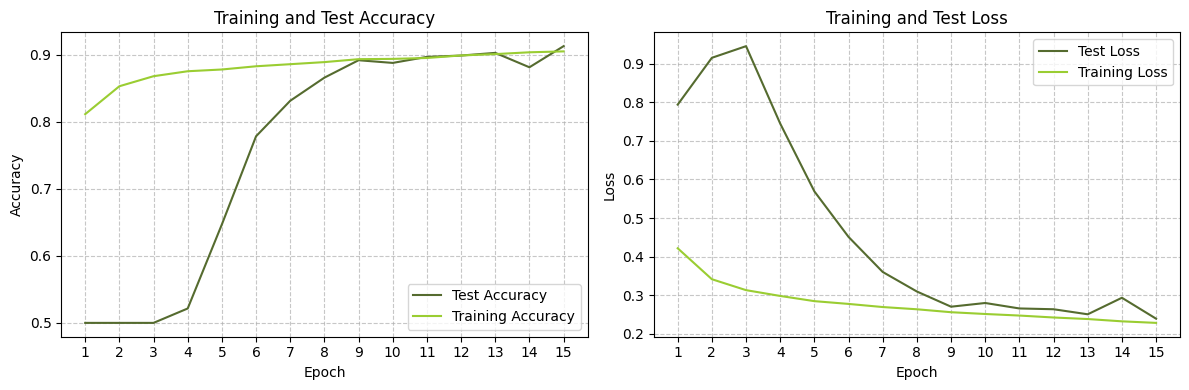

In [36]:
# Plot training and test accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(np.arange(1, len(cnn_history.history['val_accuracy']) + 1), cnn_history.history['val_accuracy'], label='Test Accuracy', color='darkolivegreen')
plt.plot(np.arange(1, len(cnn_history.history['accuracy']) + 1), cnn_history.history['accuracy'], label='Training Accuracy', color='yellowgreen')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(range(1, len(cnn_history.history['val_accuracy']) + 1))
plt.legend()

# Plot training and test loss values
plt.subplot(1, 2, 2)
plt.plot(np.arange(1, len(cnn_history.history['val_loss']) + 1), cnn_history.history['val_loss'], label='Test Loss', color='darkolivegreen')
plt.plot(np.arange(1, len(cnn_history.history['loss']) + 1), cnn_history.history['loss'], label='Training Loss', color='yellowgreen')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(range(1, len(cnn_history.history['val_loss']) + 1))
plt.legend()

plt.tight_layout()
plt.show()

### Model Evaluation Metrics

In [37]:
# Evaluate the model on the test data and get predictions
predicted_probabilities = cnn_model.predict(test_generator)

# Convert probabilities to binary predictions (0 or 1)
predicted_labels = np.round(predicted_probabilities).astype(np.int32)[:, 0]  # [:, 0] is the probabily to mistake.

# Get true labels
true_labels = test_generator.classes

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(true_labels, predicted_labels)

# Calculate Accuracy
accuracy = accuracy_score(true_labels, predicted_labels)

# Calculate Precision
precision = precision_score(true_labels, predicted_labels)

# Calculate Recall
recall = recall_score(true_labels, predicted_labels)

print(f'MSE:       {mse:.5f}')
print(f'Accuracy:  {accuracy:.5f}')
print(f'Precision: {precision:.5f}')
print(f'Recall:    {recall:.5f}')

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 176ms/step
MSE:       0.08700
Accuracy:  0.91300
Precision: 0.90175
Recall:    0.92700


### Classification Report

In [38]:
# Generate classification report
report = classification_report(true_labels, predicted_labels, target_names=["Benign", "Malignant"])
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

      Benign       0.92      0.90      0.91      1000
   Malignant       0.90      0.93      0.91      1000

    accuracy                           0.91      2000
   macro avg       0.91      0.91      0.91      2000
weighted avg       0.91      0.91      0.91      2000



### Confusion Matrix

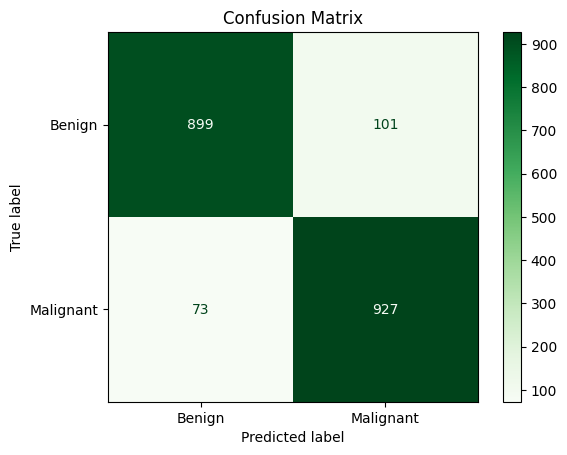

In [39]:
# Generate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benign", "Malignant"])
disp.plot(cmap='Greens', values_format='d')
plt.title("Confusion Matrix")
plt.show()

## Comparation

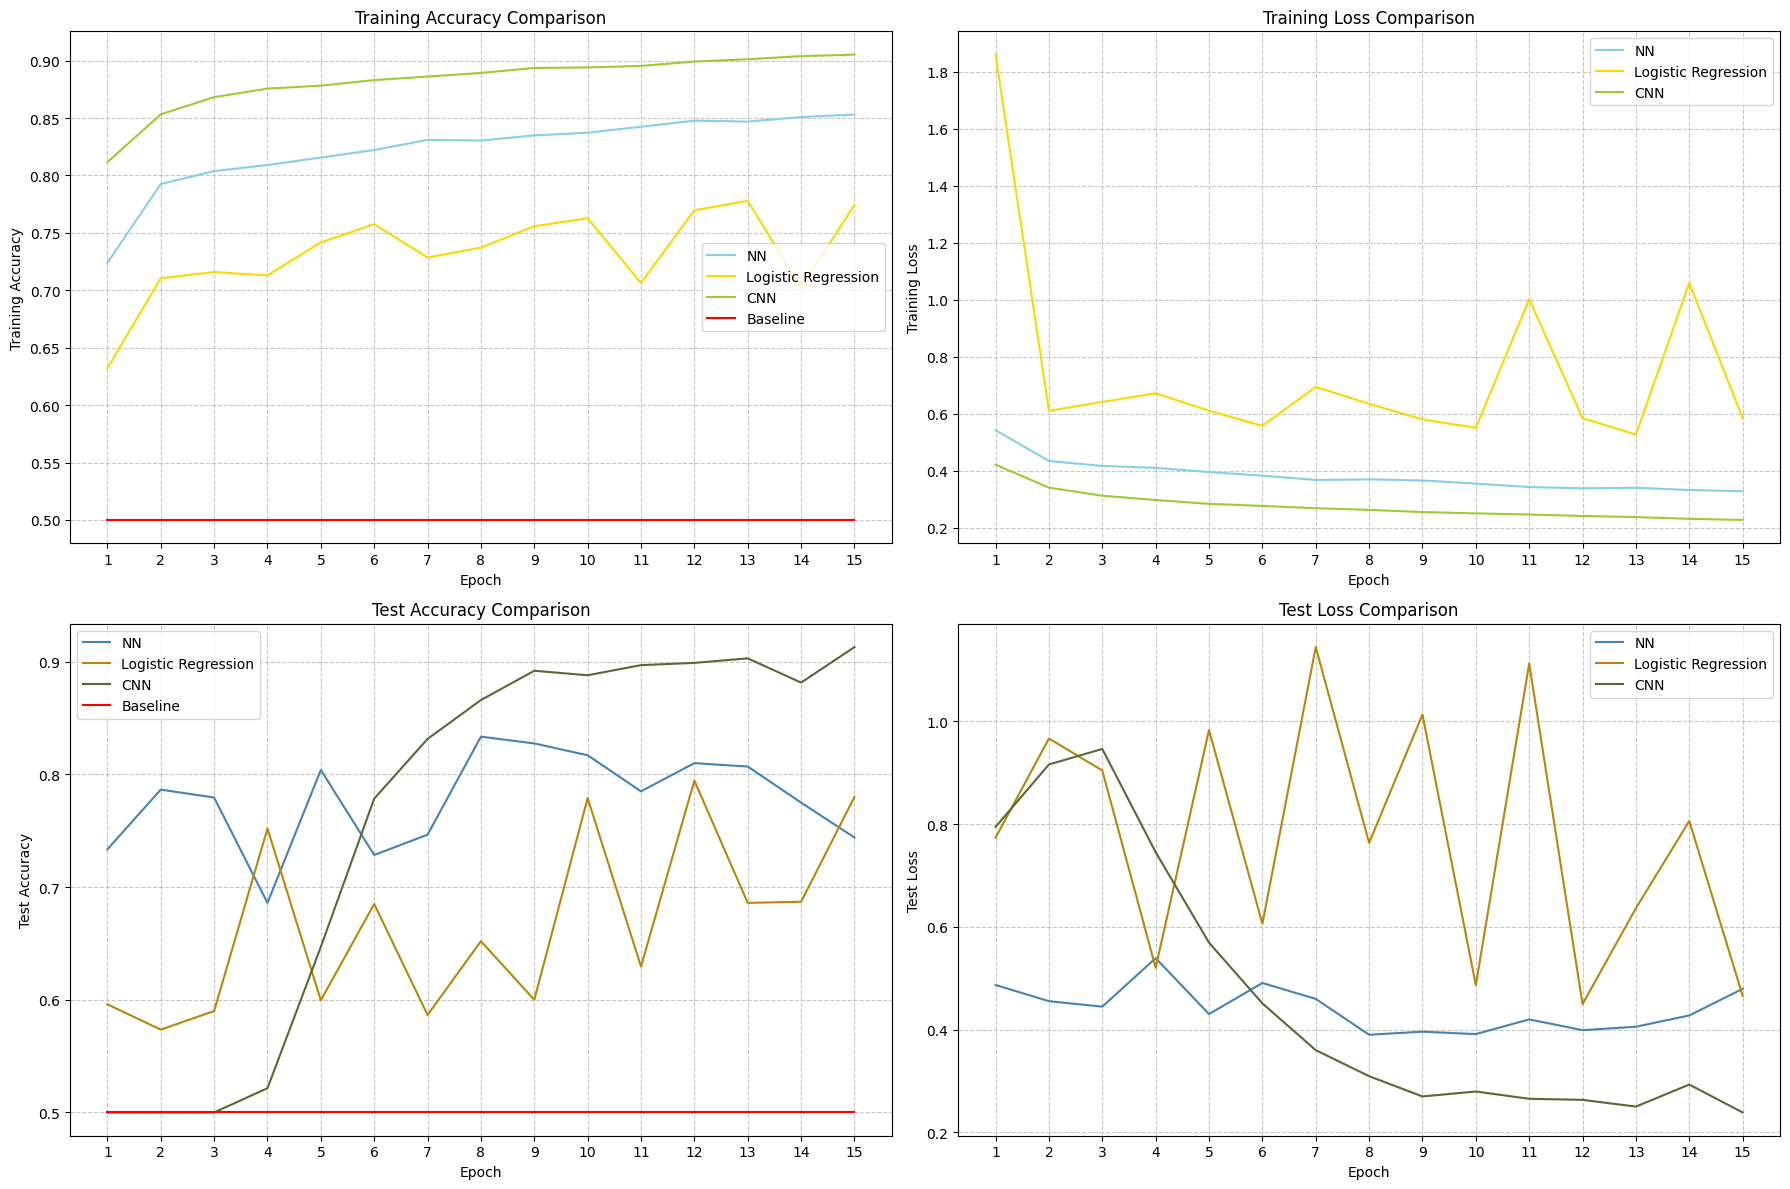

In [40]:
# Create a figure with 4 subplots
plt.figure(figsize=(18, 12))

# Comparison of Training Accuracy for all models
plt.subplot(2, 2, 1)
plt.plot(np.arange(1, len(history.history['accuracy']) + 1), history.history['accuracy'], label='NN', color="skyblue")
plt.plot(np.arange(1, len(lr_history.history['accuracy']) + 1), lr_history.history['accuracy'], label='Logistic Regression', color='gold')
plt.plot(np.arange(1, len(cnn_history.history['accuracy']) + 1), cnn_history.history['accuracy'], label='CNN', color='yellowgreen')
plt.plot(np.arange(1, len(history.history['accuracy']) + 1), [baseline_accuracy] * len(history.history['accuracy']), label='Baseline', color='red')
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.title('Training Accuracy Comparison')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(range(1, len(history.history['accuracy']) + 1))
plt.legend()

# Comparison of Training Loss for all models
plt.subplot(2, 2, 2)
plt.plot(np.arange(1, len(history.history['loss']) + 1), history.history['loss'], label='NN', color="skyblue")
plt.plot(np.arange(1, len(lr_history.history['loss']) + 1), lr_history.history['loss'], label='Logistic Regression', color='gold')
plt.plot(np.arange(1, len(cnn_history.history['loss']) + 1), cnn_history.history['loss'], label='CNN', color='yellowgreen')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss Comparison')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(range(1, len(history.history['loss']) + 1))
plt.legend()

# Comparison of Test Accuracy for all models
plt.subplot(2, 2, 3)
plt.plot(np.arange(1, len(history.history['val_accuracy']) + 1), history.history['val_accuracy'], label='NN', color="steelblue")
plt.plot(np.arange(1, len(lr_history.history['val_accuracy']) + 1), lr_history.history['val_accuracy'], label='Logistic Regression', color='darkgoldenrod')
plt.plot(np.arange(1, len(cnn_history.history['val_accuracy']) + 1), cnn_history.history['val_accuracy'], label='CNN', color='darkolivegreen')
plt.plot(np.arange(1, len(history.history['val_accuracy']) + 1), [baseline_accuracy] * len(history.history['val_accuracy']), label='Baseline', color='red')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy Comparison')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(range(1, len(history.history['val_accuracy']) + 1))
plt.legend()

# Comparison of Test Loss for all models
plt.subplot(2, 2, 4)
plt.plot(np.arange(1, len(history.history['val_loss']) + 1), history.history['val_loss'], label='NN', color="steelblue")
plt.plot(np.arange(1, len(lr_history.history['val_loss']) + 1), lr_history.history['val_loss'], label='Logistic Regression', color='darkgoldenrod')
plt.plot(np.arange(1, len(cnn_history.history['val_loss']) + 1), cnn_history.history['val_loss'], label='CNN', color='darkolivegreen')
plt.xlabel('Epoch')
plt.ylabel('Test Loss')
plt.title('Test Loss Comparison')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(range(1, len(history.history['val_loss']) + 1))
plt.legend()

# Adjust layout for better visualization
plt.tight_layout()

# Show the combined plot
plt.show()


# Report

## Prediction Results

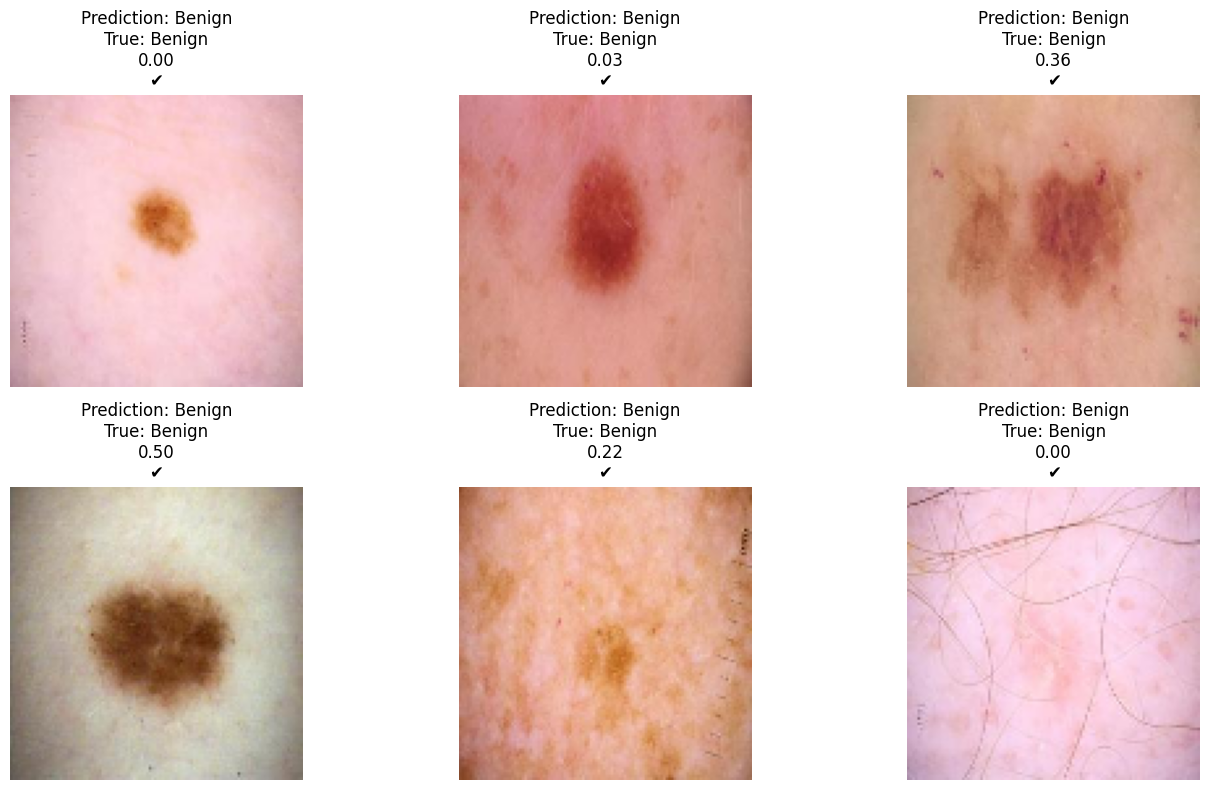

In [41]:
# Get a batch of images and labels from the test generator
batch_images, batch_labels = test_generator.__next__()

# Select 6 random indices from the batch
random_indices = np.random.choice(len(batch_labels), 6, replace=False)

# Create a figure with 2 rows and 3 columns
plt.figure(figsize=(14, 8))

# Display images with predicted and true labels
for i, index in enumerate(random_indices, start=1):
    plt.subplot(2, 3, i)
    plt.imshow(batch_images[index])
    plt.axis('off')
    
    # Determine the predicted class based on a threshold (e.g., 0.5)
    if model_type == 'baseLine':
        predicted_class = baseline_majority_class
    else:
        predicted_class = 1 if predicted_probabilities[index][0] >= 0.5 else 0
    
    # Check if the prediction is correct
    is_correct = predicted_class == batch_labels[index]
    
    # Use checkmark (✔) for correct and cross (✘) for incorrect
    sign = "✔" if is_correct else "✘"
    
    # Display prediction probability, predicted class, and true class
    plt.title(f"Prediction: {'Malignant' if predicted_class == 1 else 'Benign'}\nTrue: {'Malignant' if batch_labels[index] == 1 else 'Benign'}\n{predicted_probabilities[index][0]:.2f}\n{sign}")

# Adjust layout for better visualization
plt.tight_layout()
plt.show()